In [1]:
import os 
os.chdir("../")
import numpy as np
import scanpy as sc
import anndata as ad
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(5, 5)
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.figdir = '../figures'
sc.set_figure_params(dpi=200)
#results_file = './write/results.h5ad'


%load_ext autoreload
%autoreload 2 

/home/icb/carlo.dedonno/anaconda3/envs/tf2/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.16.4 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [13]:
data_name = "Tuft"
specific_celltype = "Tuft"
conditions = ['Control', 'Hpoly.Day3', 'Hpoly.Day10', 'Salmonella']
target_conditions = ["Hpoly.Day3", "Hpoly.Day10", "Salmonella"]
cell_type_key = "cell_label"
condition_key = "condition"

In [4]:
adata = sc.read(f"./data/processed/{data_name}_count.h5ad")
adata = adata[adata.obs[condition_key].isin(conditions)]
adata

View of AnnData object with n_obs × n_vars = 9842 × 15215 
    obs: 'batch', 'barcode', 'condition', 'cell_label'

In [7]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:01)


/home/icb/carlo.dedonno/anaconda3/envs/tf2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes=7000, subset=True)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [9]:
import trvae

Using TensorFlow backend.


In [14]:
train_adata, valid_adata = trvae.utils.train_test_split(adata, 0.80)
print(train_adata.shape, valid_adata.shape)

(7873, 6999) (1969, 6999)


In [15]:
net_train_adata = train_adata[~((train_adata.obs[cell_type_key] == specific_celltype) & (train_adata.obs[condition_key].isin(target_conditions)))]
net_valid_adata = valid_adata[~((valid_adata.obs[cell_type_key] == specific_celltype) & (valid_adata.obs[condition_key].isin(target_conditions)))]

In [16]:
network = trvae.models.trVAE(x_dimension=net_train_adata.shape[1],
                                z_dimension=60,
                                mmd_dimension=128, 
                                n_conditions=len(net_train_adata.obs[condition_key].unique()),
                                alpha=1e-6,
                                beta=100,
                                eta=100,
                                clip_value=100,
                                lambda_l1=0.0,
                                lambda_l2=0.0,
                                learning_rate=0.001,
                                dropout_rate=0.2,
                                output_activation='relu')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 6999)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 4)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 7003)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          1793024     concatenate_1[0][0]        

In [17]:
label_encoder = {'Control': 0, 'Hpoly.Day3': 1, 'Hpoly.Day10': 2, 'Salmonella': 3}

In [ ]:
network.train(net_train_adata,
              net_valid_adata,
              label_encoder,
              condition_key,
              n_epochs=5000,
              batch_size=512,
              verbose=5,
              early_stop_limit=750,
              lr_reducer=0,
              shuffle=True,
              )

 |--------------------| 1.0%  - loss: 17338.5160 - kl_sse_loss: 17319.1758 - mmd_loss: 16.1204 - val_loss: 16687.6268 - val_kl_sse_loss: 16673.0215 - val_mmd_loss: 18.1349

/home/icb/carlo.dedonno/anaconda3/envs/tf2/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


 |██████████----------| 53.4%  - loss: 16546.3510 - kl_sse_loss: 16538.1738 - mmd_loss: 5.5724 - val_loss: 15956.4624 - val_kl_sse_loss: 15953.3076 - val_mmd_loss: 6.297209

In [40]:
train_labels, _ = trvae.tl.label_encoder(net_train_adata, label_encoder, condition_key)
latent_with_true_labels = network.to_latent(net_train_adata, train_labels)
mmd_with_true_labels = network.to_mmd_layer(net_train_adata, train_labels, feed_fake=-1)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA with n_comps = 50
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

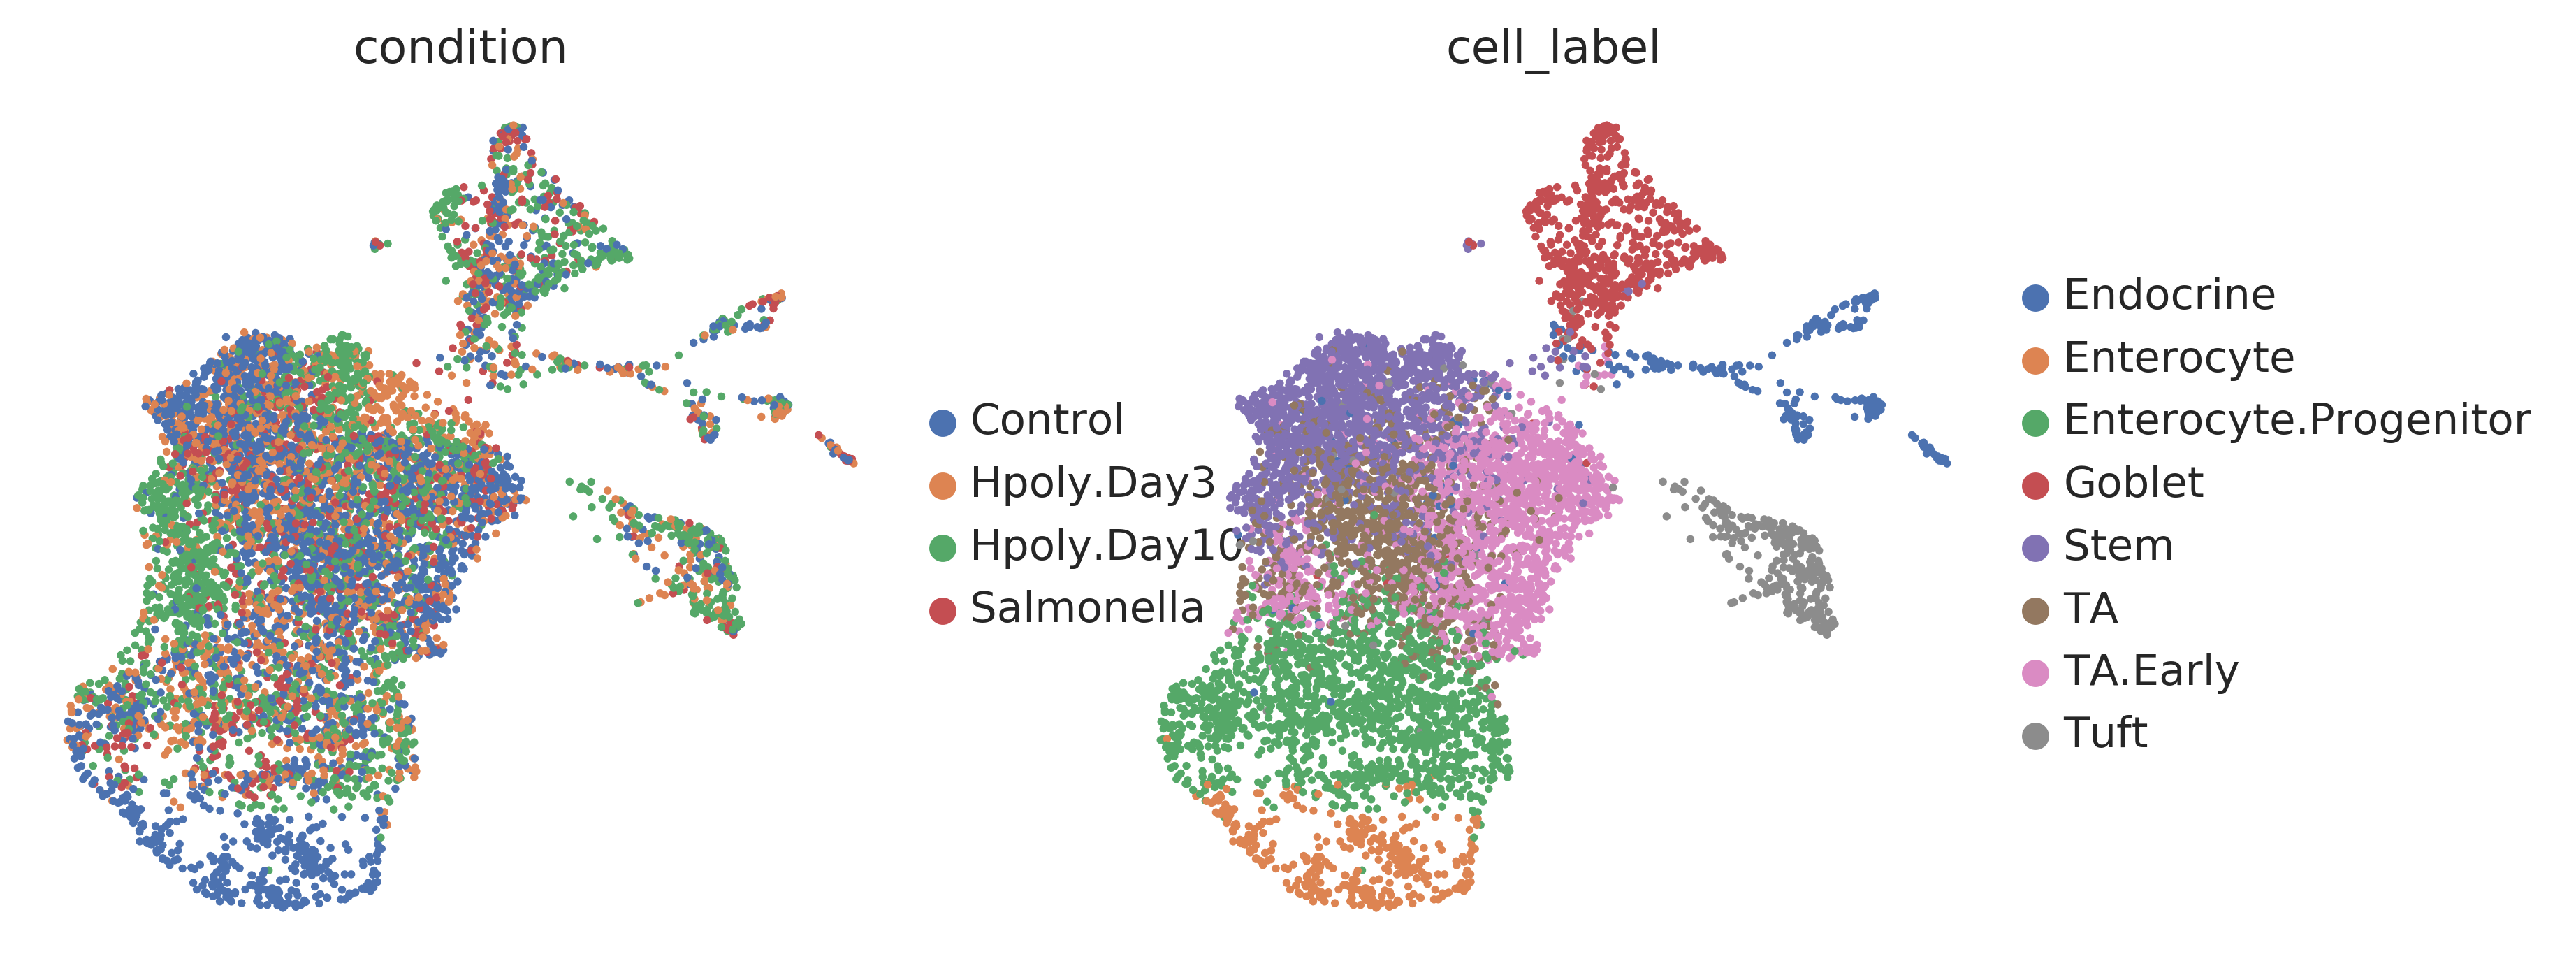

In [41]:
sc.pp.neighbors(latent_with_true_labels)
sc.tl.umap(latent_with_true_labels)
sc.pl.umap(latent_with_true_labels, color=[condition_key, cell_type_key],
           show=True,
           wspace=0.15,
           frameon=False)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

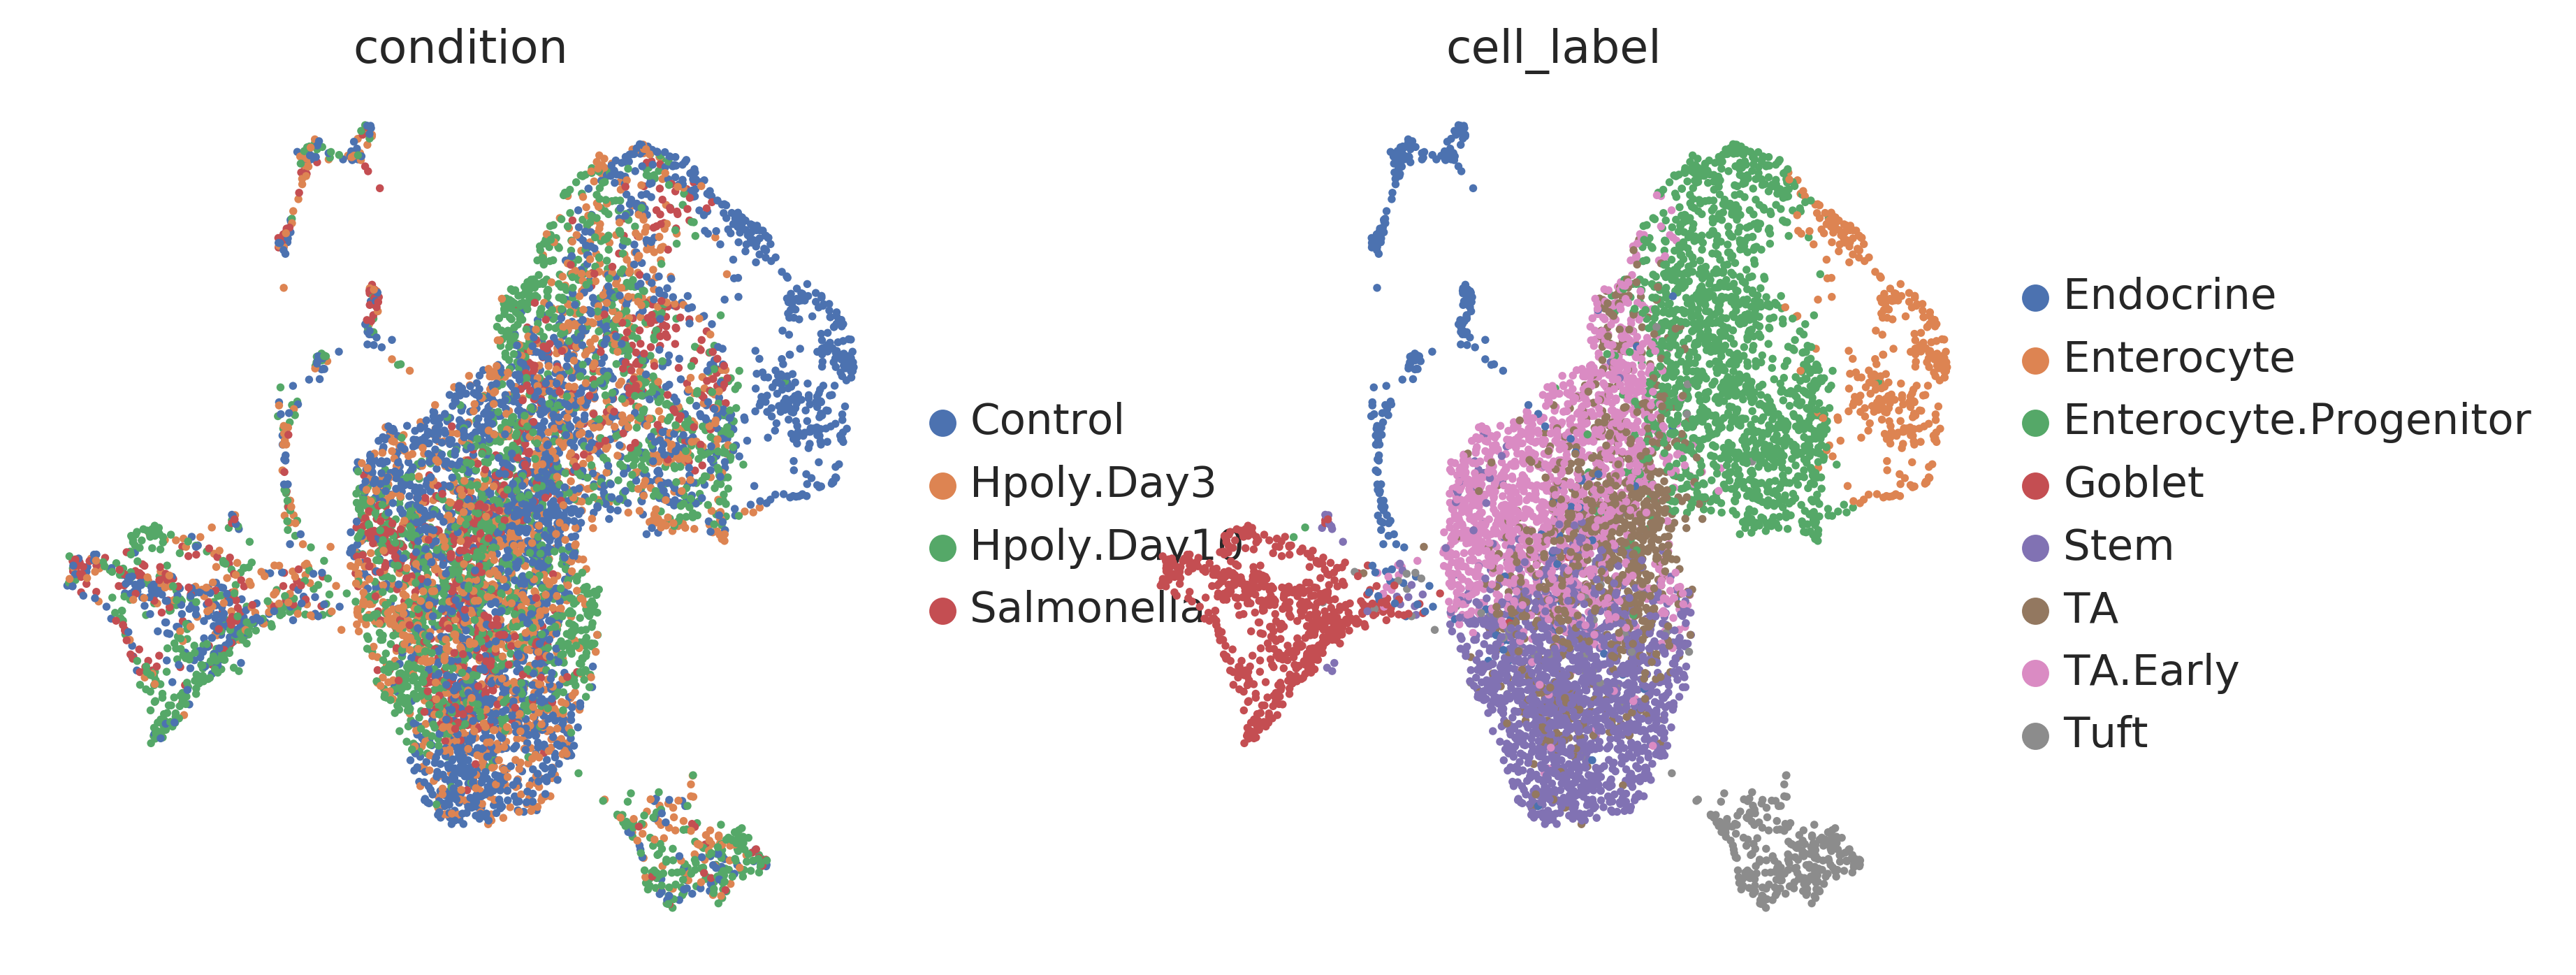

In [42]:
sc.pp.neighbors(mmd_with_true_labels)
sc.tl.umap(mmd_with_true_labels)
sc.pl.umap(mmd_with_true_labels, color=[condition_key, cell_type_key],
           show=True,
           wspace=0.15,
           frameon=False)

In [43]:
cell_type_adata = train_adata[train_adata.obs[cell_type_key] == specific_celltype]

In [44]:
def predict_transition(adata, source_cond, target_cond):
    
    source_adata = adata[adata.obs[condition_key] == source_cond]
    
    source_cond_key = source_cond.split("_to_")[-1]
    source_labels = np.zeros(source_adata.shape[0]) + label_encoder[source_cond_key]
    target_labels = np.zeros(source_adata.shape[0]) + label_encoder[target_cond]

    pred_target = network.predict(source_adata,
                                  encoder_labels=source_labels,
                                  decoder_labels=target_labels,
                                  )

    pred_adata = sc.AnnData(X=pred_target)
    pred_adata.obs[condition_key] = [source_cond + "_to_" + target_cond] * pred_target.shape[0]
    pred_adata.obs[cell_type_key] = [specific_celltype] * pred_target.shape[0]
    pred_adata.var_names = source_adata.var_names

    adata = adata.concatenate(pred_adata)
    return adata

In [45]:
recon_adata = predict_transition(cell_type_adata, "Control", "Hpoly.Day10")
recon_adata = recon_adata.concatenate(predict_transition(recon_adata, "Control", "Hpoly.Day3"))
recon_adata = recon_adata.concatenate(predict_transition(recon_adata, "Control", "Salmonella"))
recon_adata = recon_adata.concatenate(predict_transition(recon_adata, "Hpoly.Day3", "Hpoly.Day10"))
recon_adata = recon_adata.concatenate(predict_transition(recon_adata, "Control_to_Hpoly.Day3", "Hpoly.Day10"))
recon_adata

AnnData object with n_obs × n_vars = 32564 × 2000 
    obs: 'barcode', 'batch', 'cell_label', 'condition', 'n_counts'
    var: 'highly_variable-0-0-0-0-0', 'means-0-0-0-0-0', 'dispersions-0-0-0-0-0', 'dispersions_norm-0-0-0-0-0', 'highly_variable-0-0-1-0-0-0', 'means-0-0-1-0-0-0', 'dispersions-0-0-1-0-0-0', 'dispersions_norm-0-0-1-0-0-0', 'highly_variable-0-0-0-1-0-0', 'means-0-0-0-1-0-0', 'dispersions-0-0-0-1-0-0', 'dispersions_norm-0-0-0-1-0-0', 'highly_variable-0-0-1-0-1-0-0', 'means-0-0-1-0-1-0-0', 'dispersions-0-0-1-0-1-0-0', 'dispersions_norm-0-0-1-0-1-0-0', 'highly_variable-0-0-0-0-1-0', 'means-0-0-0-0-1-0', 'dispersions-0-0-0-0-1-0', 'dispersions_norm-0-0-0-0-1-0', 'highly_variable-0-0-1-0-0-1-0', 'means-0-0-1-0-0-1-0', 'dispersions-0-0-1-0-0-1-0', 'dispersions_norm-0-0-1-0-0-1-0', 'highly_variable-0-0-0-1-0-1-0', 'means-0-0-0-1-0-1-0', 'dispersions-0-0-0-1-0-1-0', 'dispersions_norm-0-0-0-1-0-1-0', 'highly_variable-0-0-1-0-1-0-1-0', 'means-0-0-1-0-1-0-1-0', 'dispersions-0-0-1-0

In [46]:
path = "Control_to_Hpoly.Day10"
from_condition = path.split("_to_")[-2]
to_condition = path.split("_to_")[-1]

In [47]:
pred_adata = recon_adata[recon_adata.obs[condition_key] == path]
ctrl_adata = cell_type_adata[cell_type_adata.obs[condition_key] == from_condition]
real_adata = cell_type_adata[cell_type_adata.obs[condition_key] == to_condition]
adata_pred = ctrl_adata.concatenate(pred_adata, real_adata)

In [48]:
sc.tl.rank_genes_groups(cell_type_adata,
                        groupby=condition_key,
                        groups=[to_condition],
                        reference=from_condition,
                        n_genes=100)
top_genes = cell_type_adata.uns['rank_genes_groups']['names'][to_condition]

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


reg_mean_top100: 0.9505242646600489
reg_mean_all: 0.9377976698768098


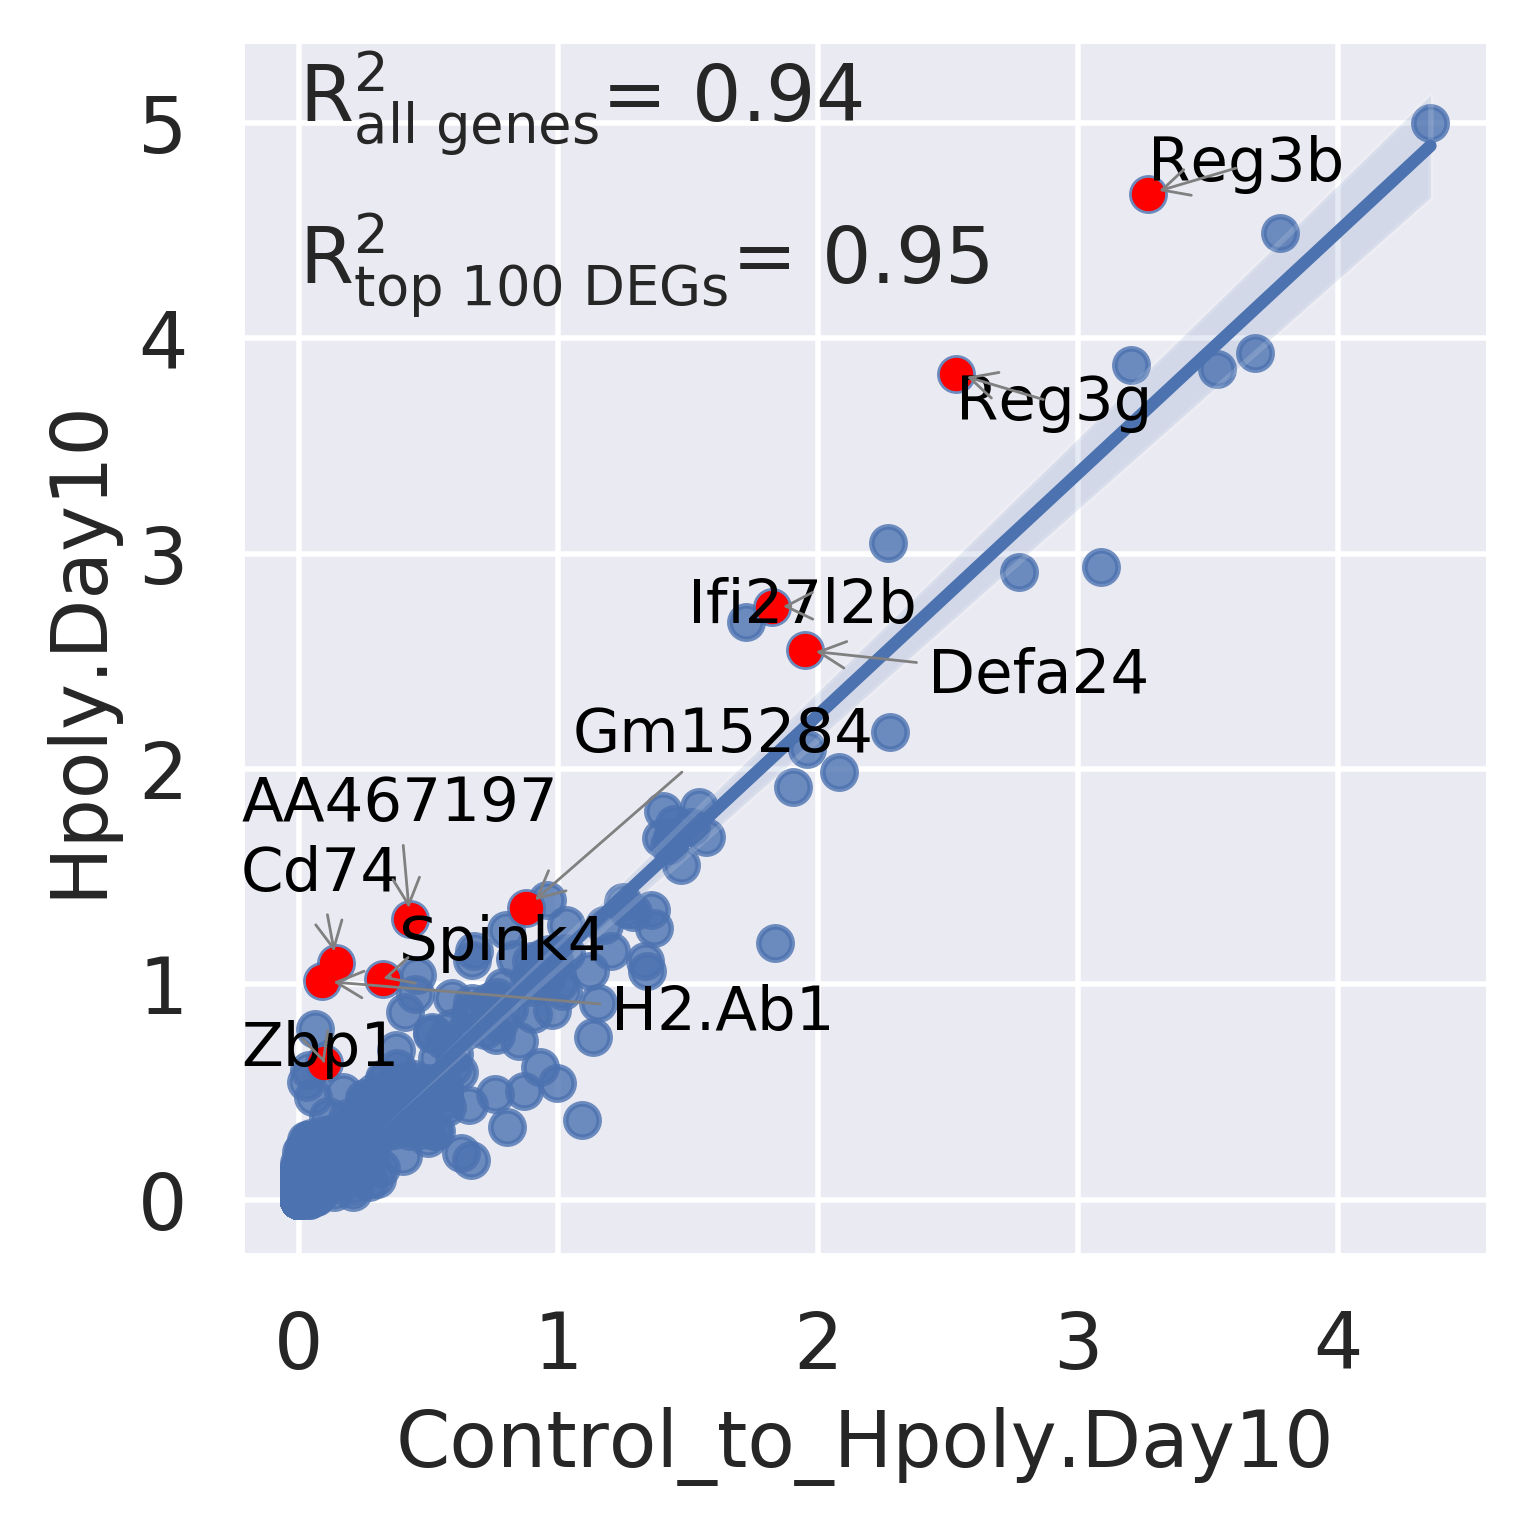

reg_var_top100: 0.6792751745473866
reg_var_all: 0.5114871567198612


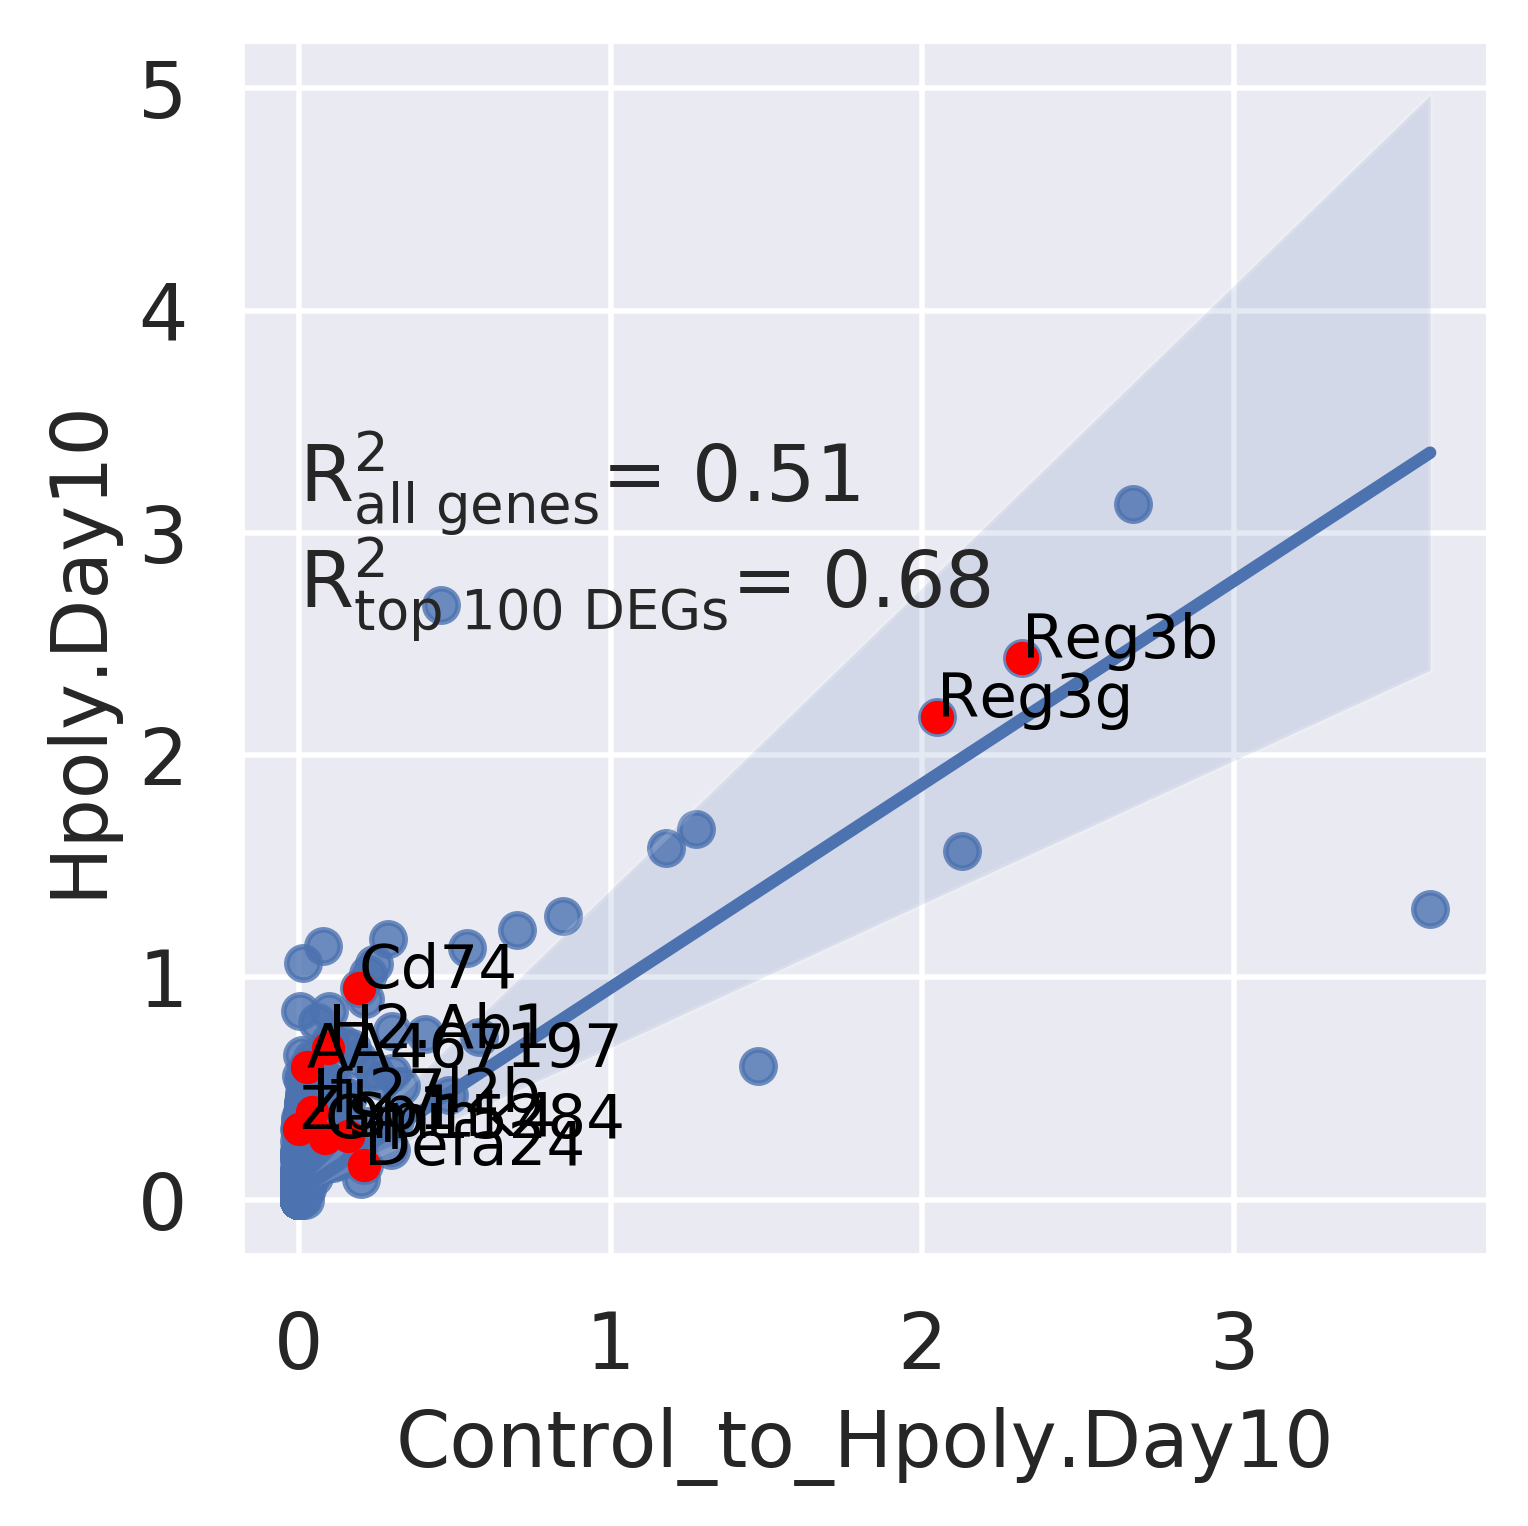

In [49]:
trvae.pl.reg_mean_plot(adata_pred,
                         top_100_genes=top_genes,
                         gene_list=top_genes[:10],
                         condition_key=condition_key,
                         axis_keys={'x': path, 'y': to_condition},
                         labels={'x': path, 'y': to_condition},
                         path_to_save=None,
                         legend=False,
                         show=True,
                         x_coeff=1.0,
                         y_coeff=0.0)

trvae.pl.reg_var_plot(adata_pred,
                     top_100_genes=top_genes,
                     gene_list=top_genes[:10],
                     condition_key=condition_key,
                     axis_keys={'x': path, 'y': to_condition},
                     labels={'x': path, 'y': to_condition},
                     path_to_save=None,
                     legend=False,
                     show=True,
                     x_coeff=1.0,
                     y_coeff=0.0)

computing PCA with n_comps = 50
    finished (0:00:00)


... storing 'barcode' as categorical
... storing 'cell_label' as categorical
... storing 'condition' as categorical
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


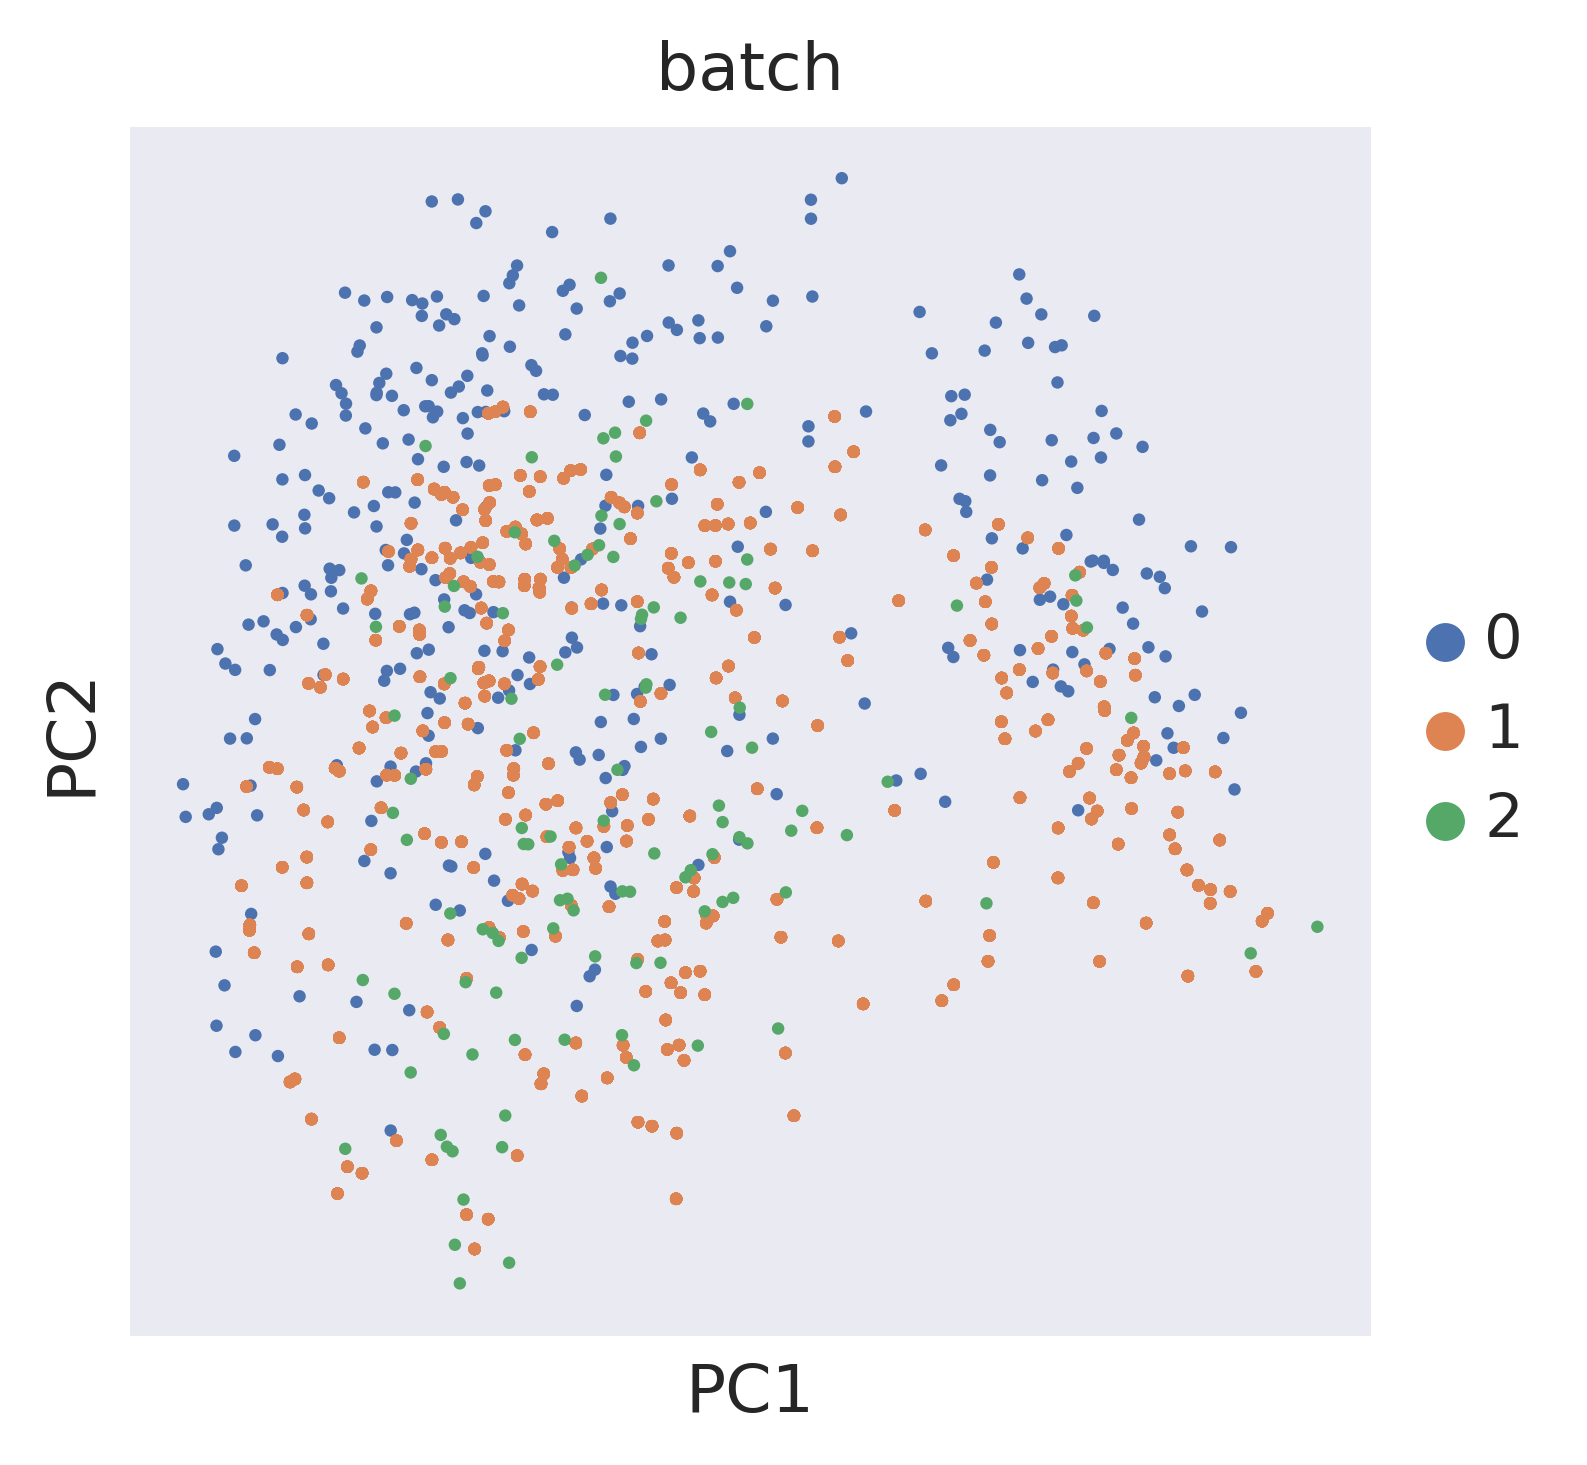

In [50]:
sc.pp.pca(adata_pred)
sc.pl.pca(adata_pred, color='batch')

In [51]:
path = "Control_to_Salmonella"
from_condition = path.split("_to_")[-2]
to_condition = path.split("_to_")[-1]

In [52]:
pred_adata = recon_adata[recon_adata.obs[condition_key] == path]
ctrl_adata = cell_type_adata[cell_type_adata.obs[condition_key] == from_condition]
real_adata = cell_type_adata[cell_type_adata.obs[condition_key] == to_condition]
adata_pred = ctrl_adata.concatenate(pred_adata, real_adata)

In [53]:
sc.tl.rank_genes_groups(cell_type_adata,
                        groupby=condition_key,
                        groups=[to_condition],
                        reference=from_condition,
                        n_genes=100)
top_genes = cell_type_adata.uns['rank_genes_groups']['names'][to_condition]

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


reg_mean_top100: 0.9414917526189205
reg_mean_all: 0.9474725265800057


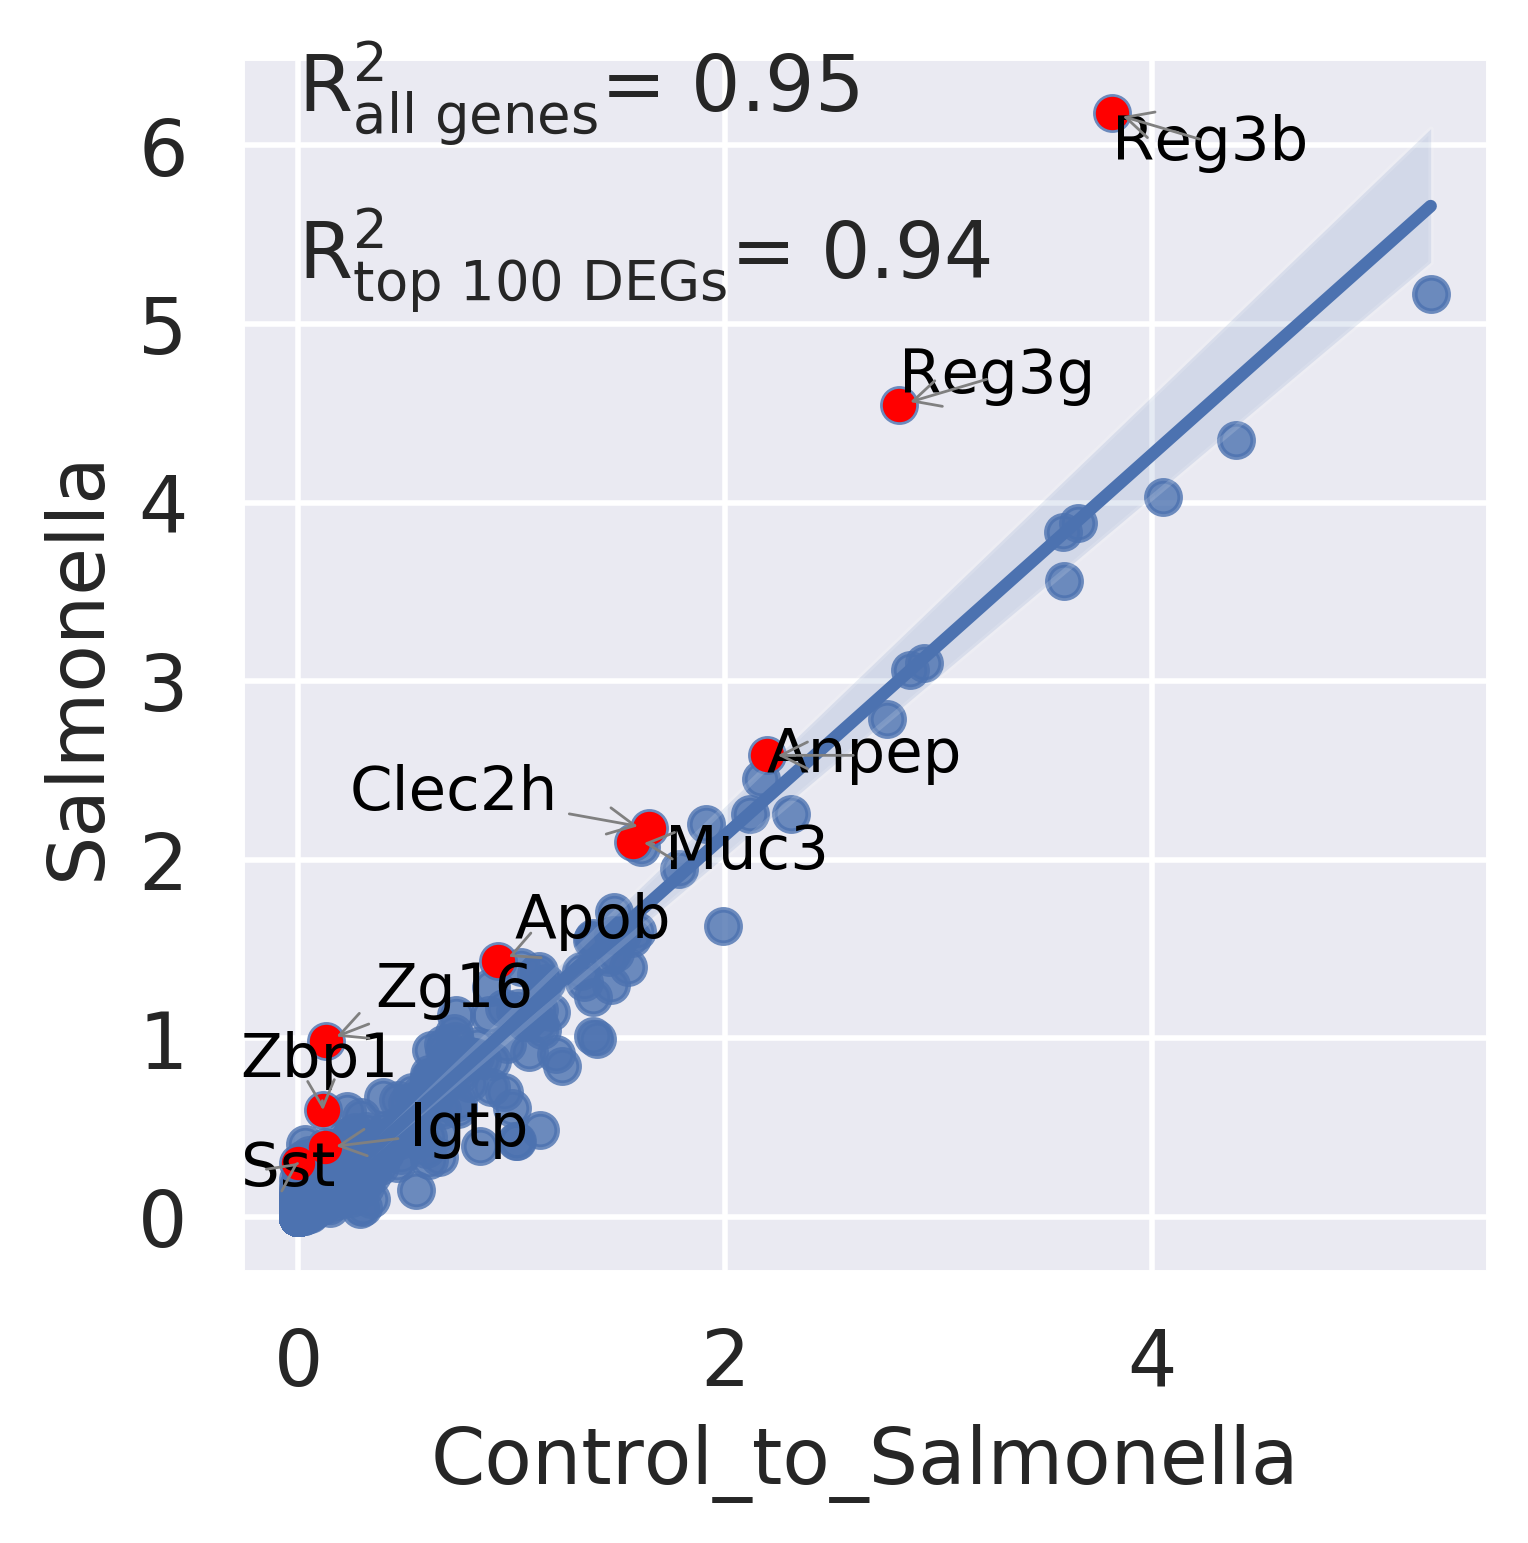

reg_var_top100: 0.3760137056838573
reg_var_all: 0.4956681887114717


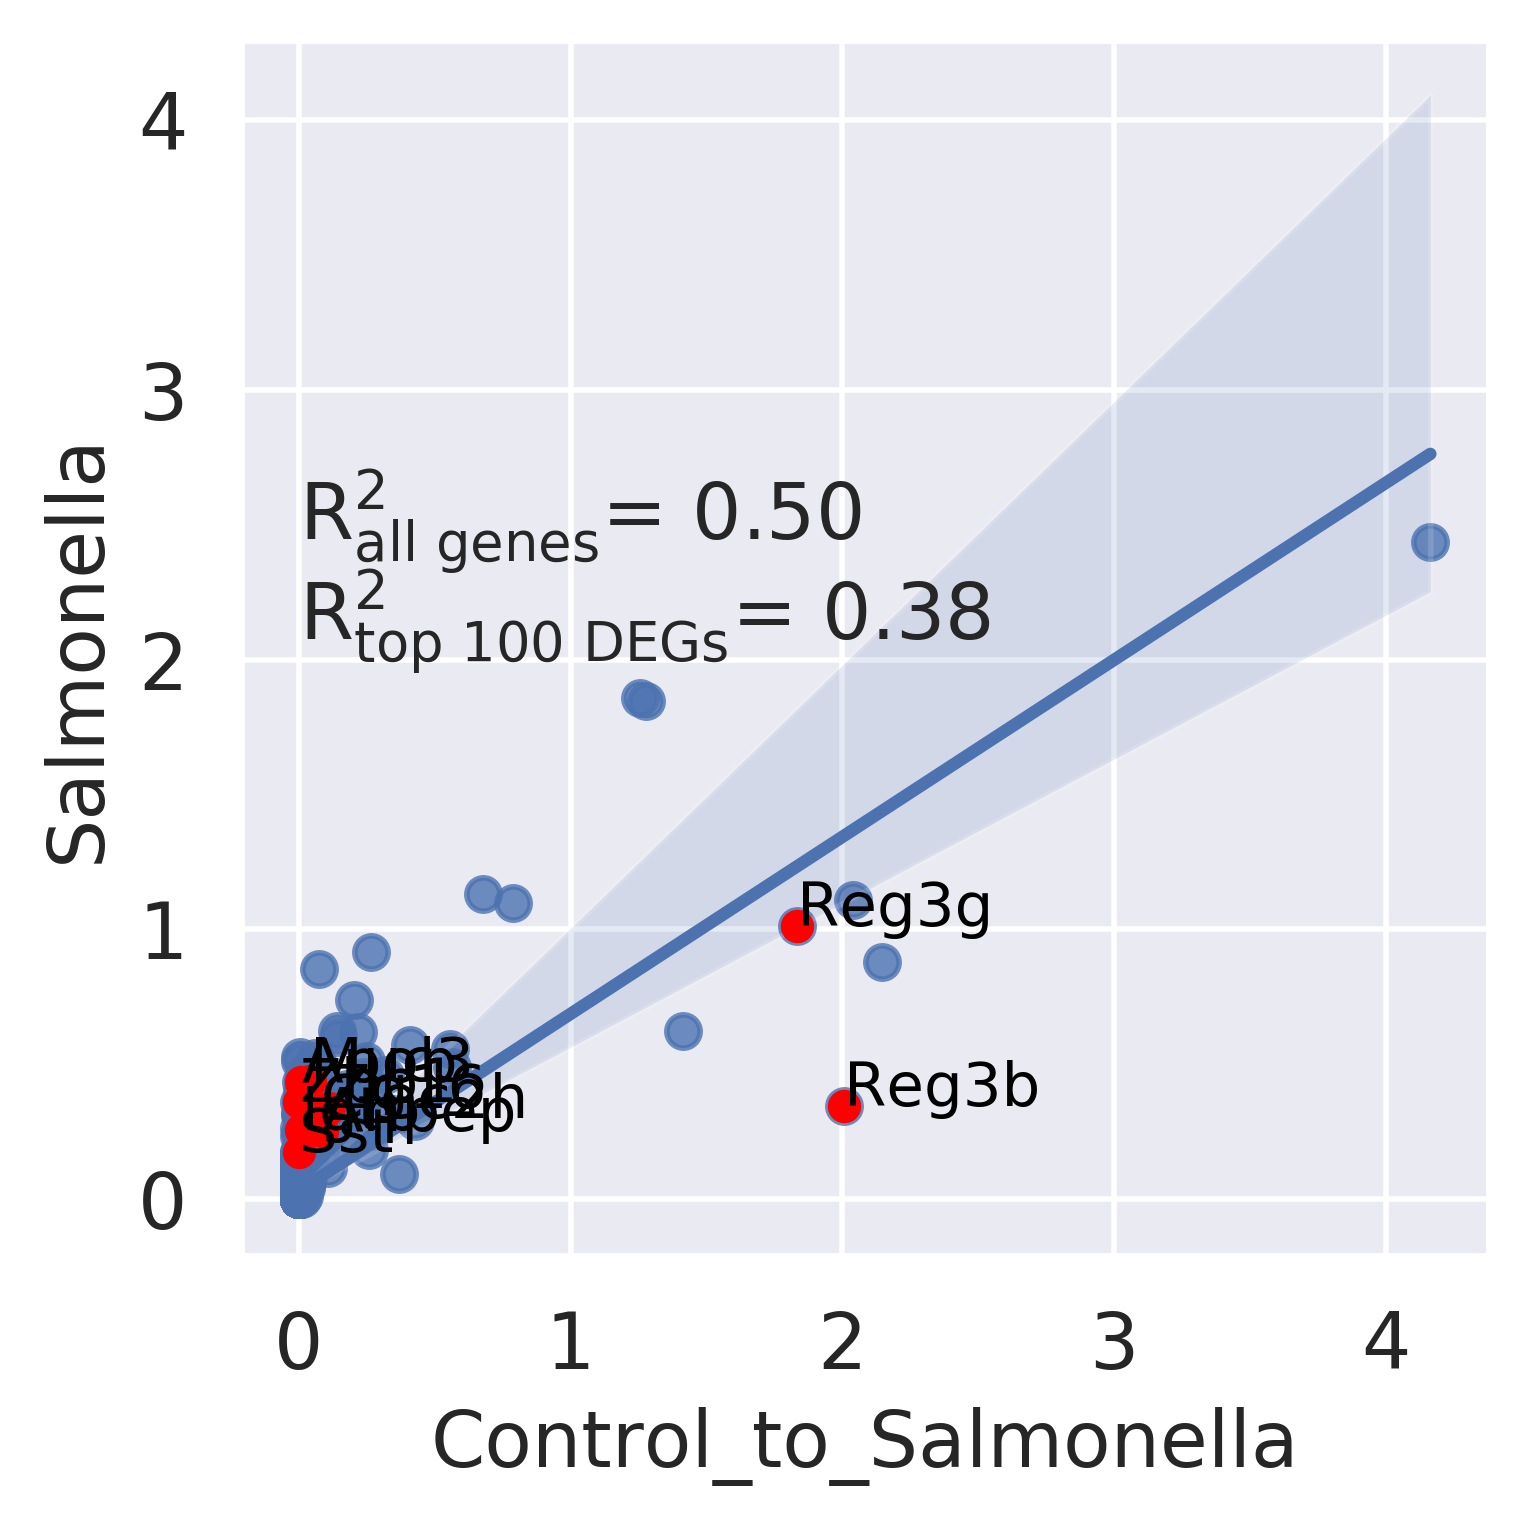

In [54]:
trvae.pl.reg_mean_plot(adata_pred,
                         top_100_genes=top_genes,
                         gene_list=top_genes[:10],
                         condition_key=condition_key,
                         axis_keys={'x': path, 'y': to_condition},
                         labels={'x': path, 'y': to_condition},
                         path_to_save=None,
                         legend=False,
                         show=True,
                         x_coeff=1.0,
                         y_coeff=0.0)

trvae.pl.reg_var_plot(adata_pred,
                     top_100_genes=top_genes,
                     gene_list=top_genes[:10],
                     condition_key=condition_key,
                     axis_keys={'x': path, 'y': to_condition},
                     labels={'x': path, 'y': to_condition},
                     path_to_save=None,
                     legend=False,
                     show=True,
                     x_coeff=1.0,
                     y_coeff=0.0)

computing PCA with n_comps = 50
    finished (0:00:00)


... storing 'barcode' as categorical
... storing 'cell_label' as categorical
... storing 'condition' as categorical
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


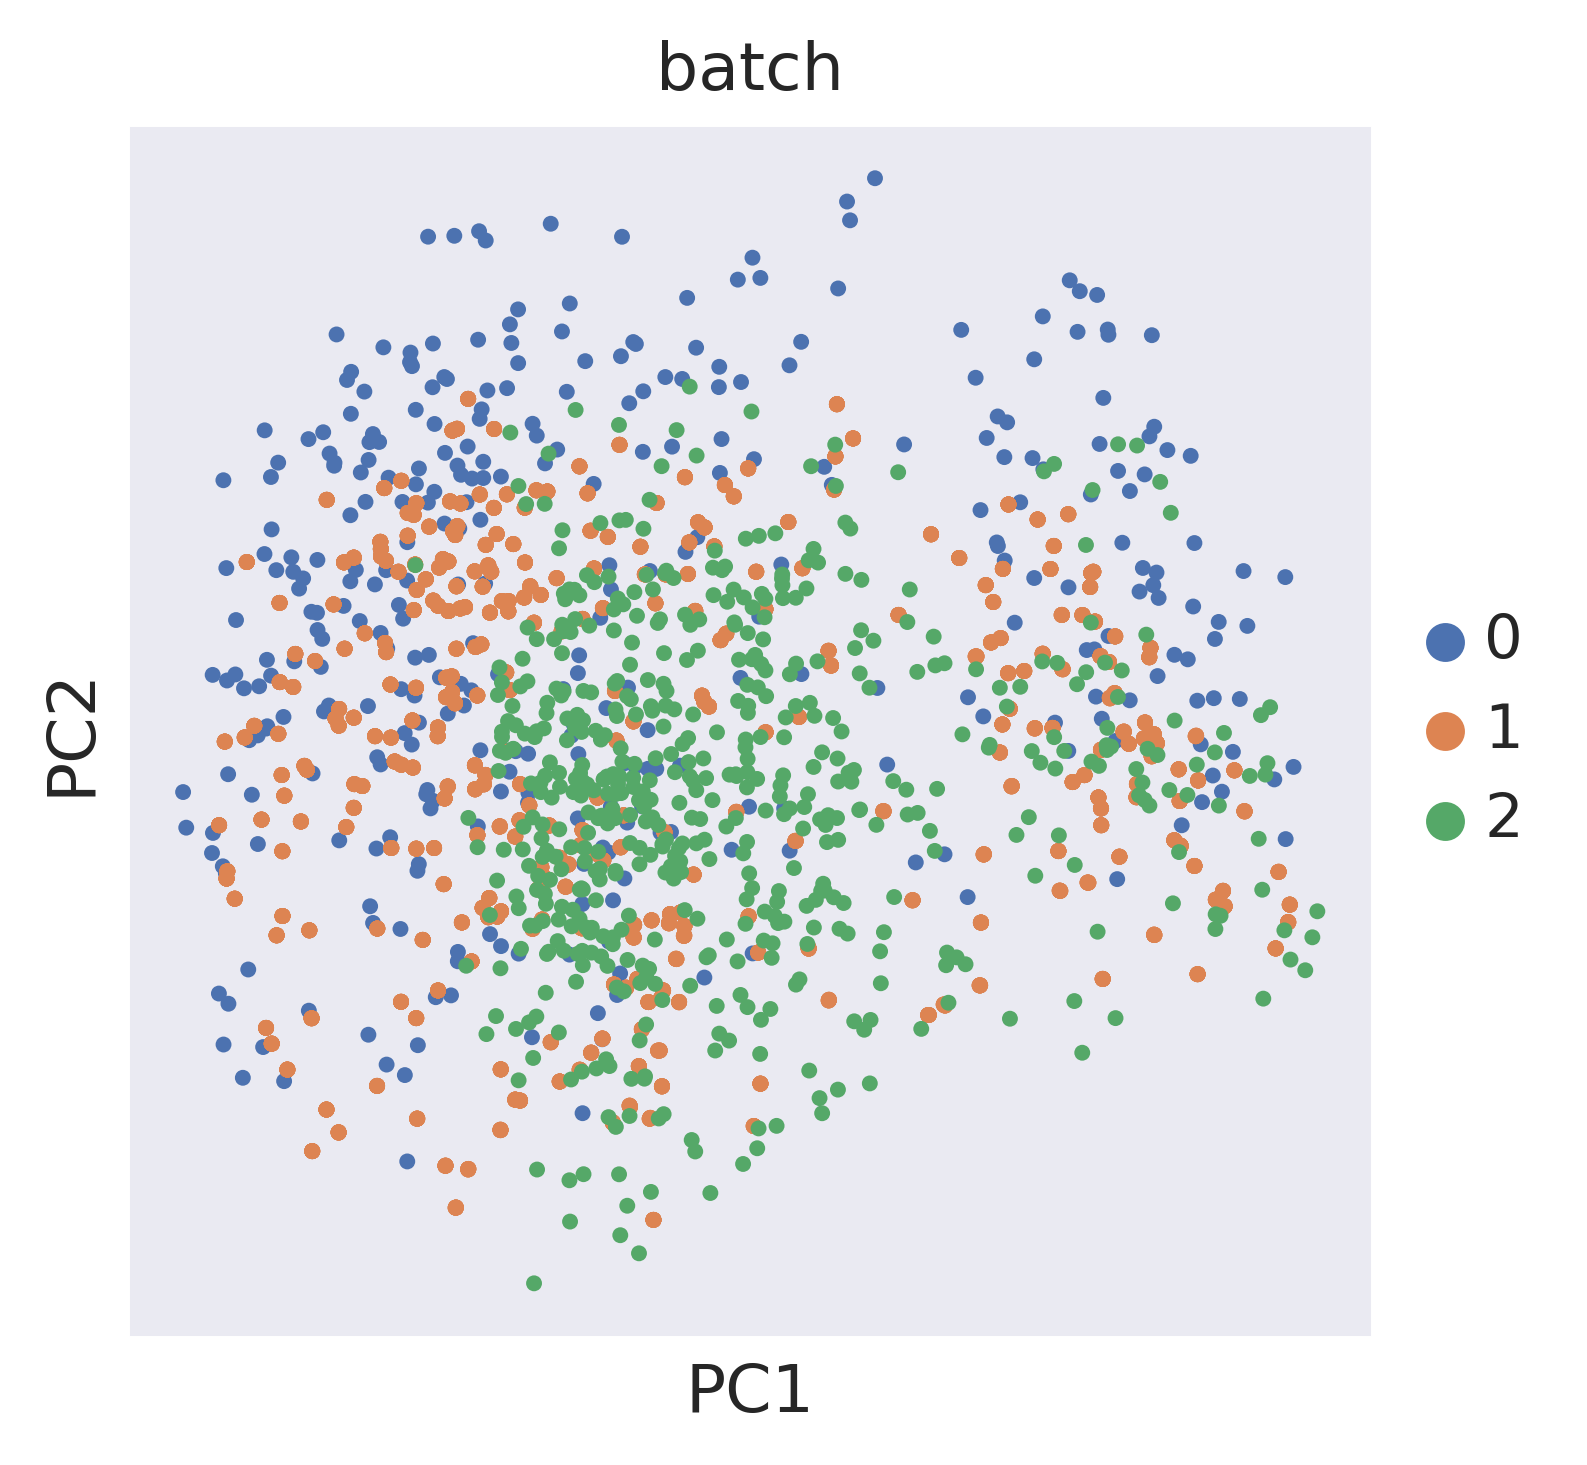

In [55]:
sc.pp.pca(adata_pred)
sc.pl.pca(adata_pred, color='batch')

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP


/home/icb/carlo.dedonno/anaconda3/envs/tf2/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 101 separate connected components using meta-embedding (experimental)
  n_components


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


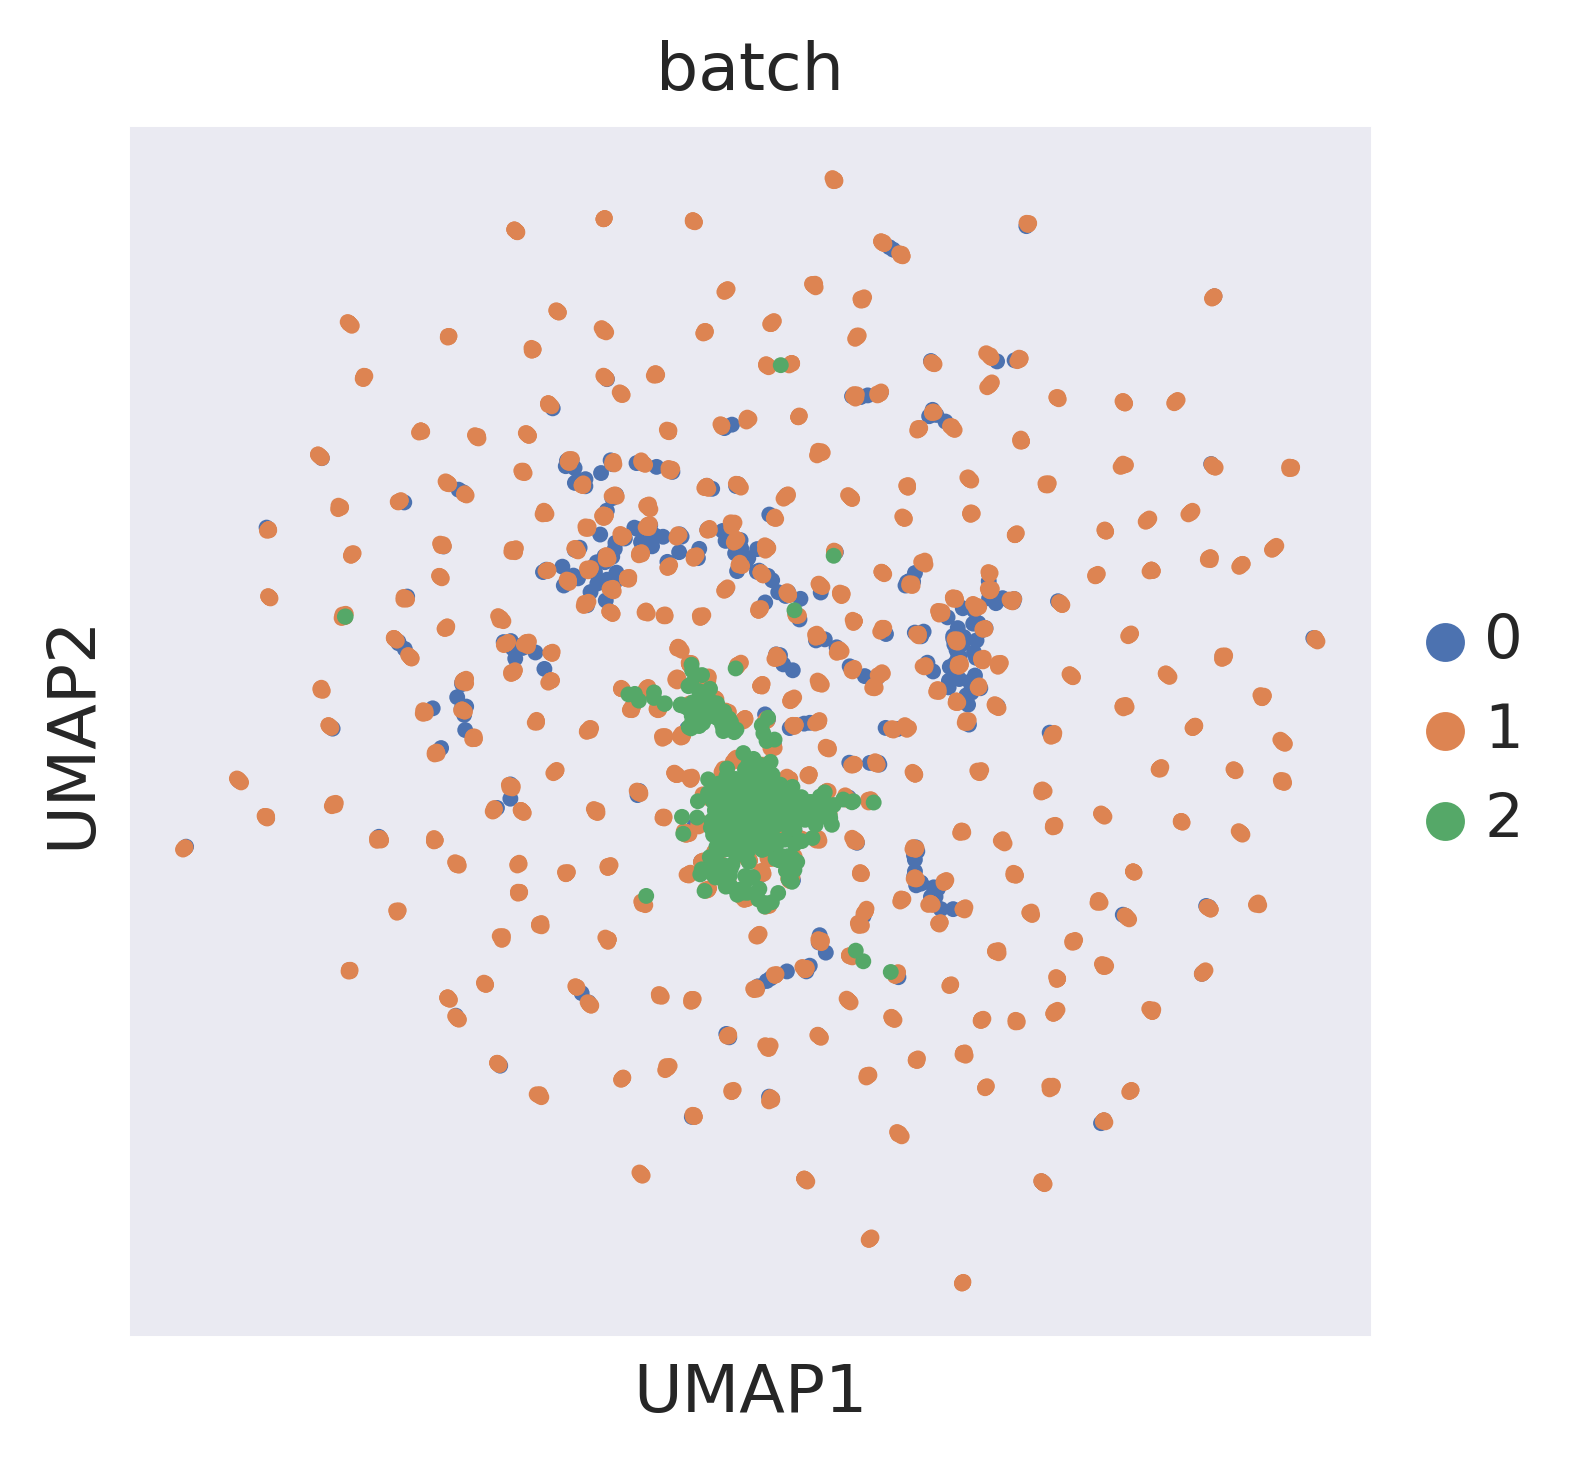

In [56]:
sc.pp.neighbors(adata_pred)
sc.tl.umap(adata_pred)
sc.pl.umap(adata_pred, color='batch')

normalizing counts per cell
    finished (0:00:00)


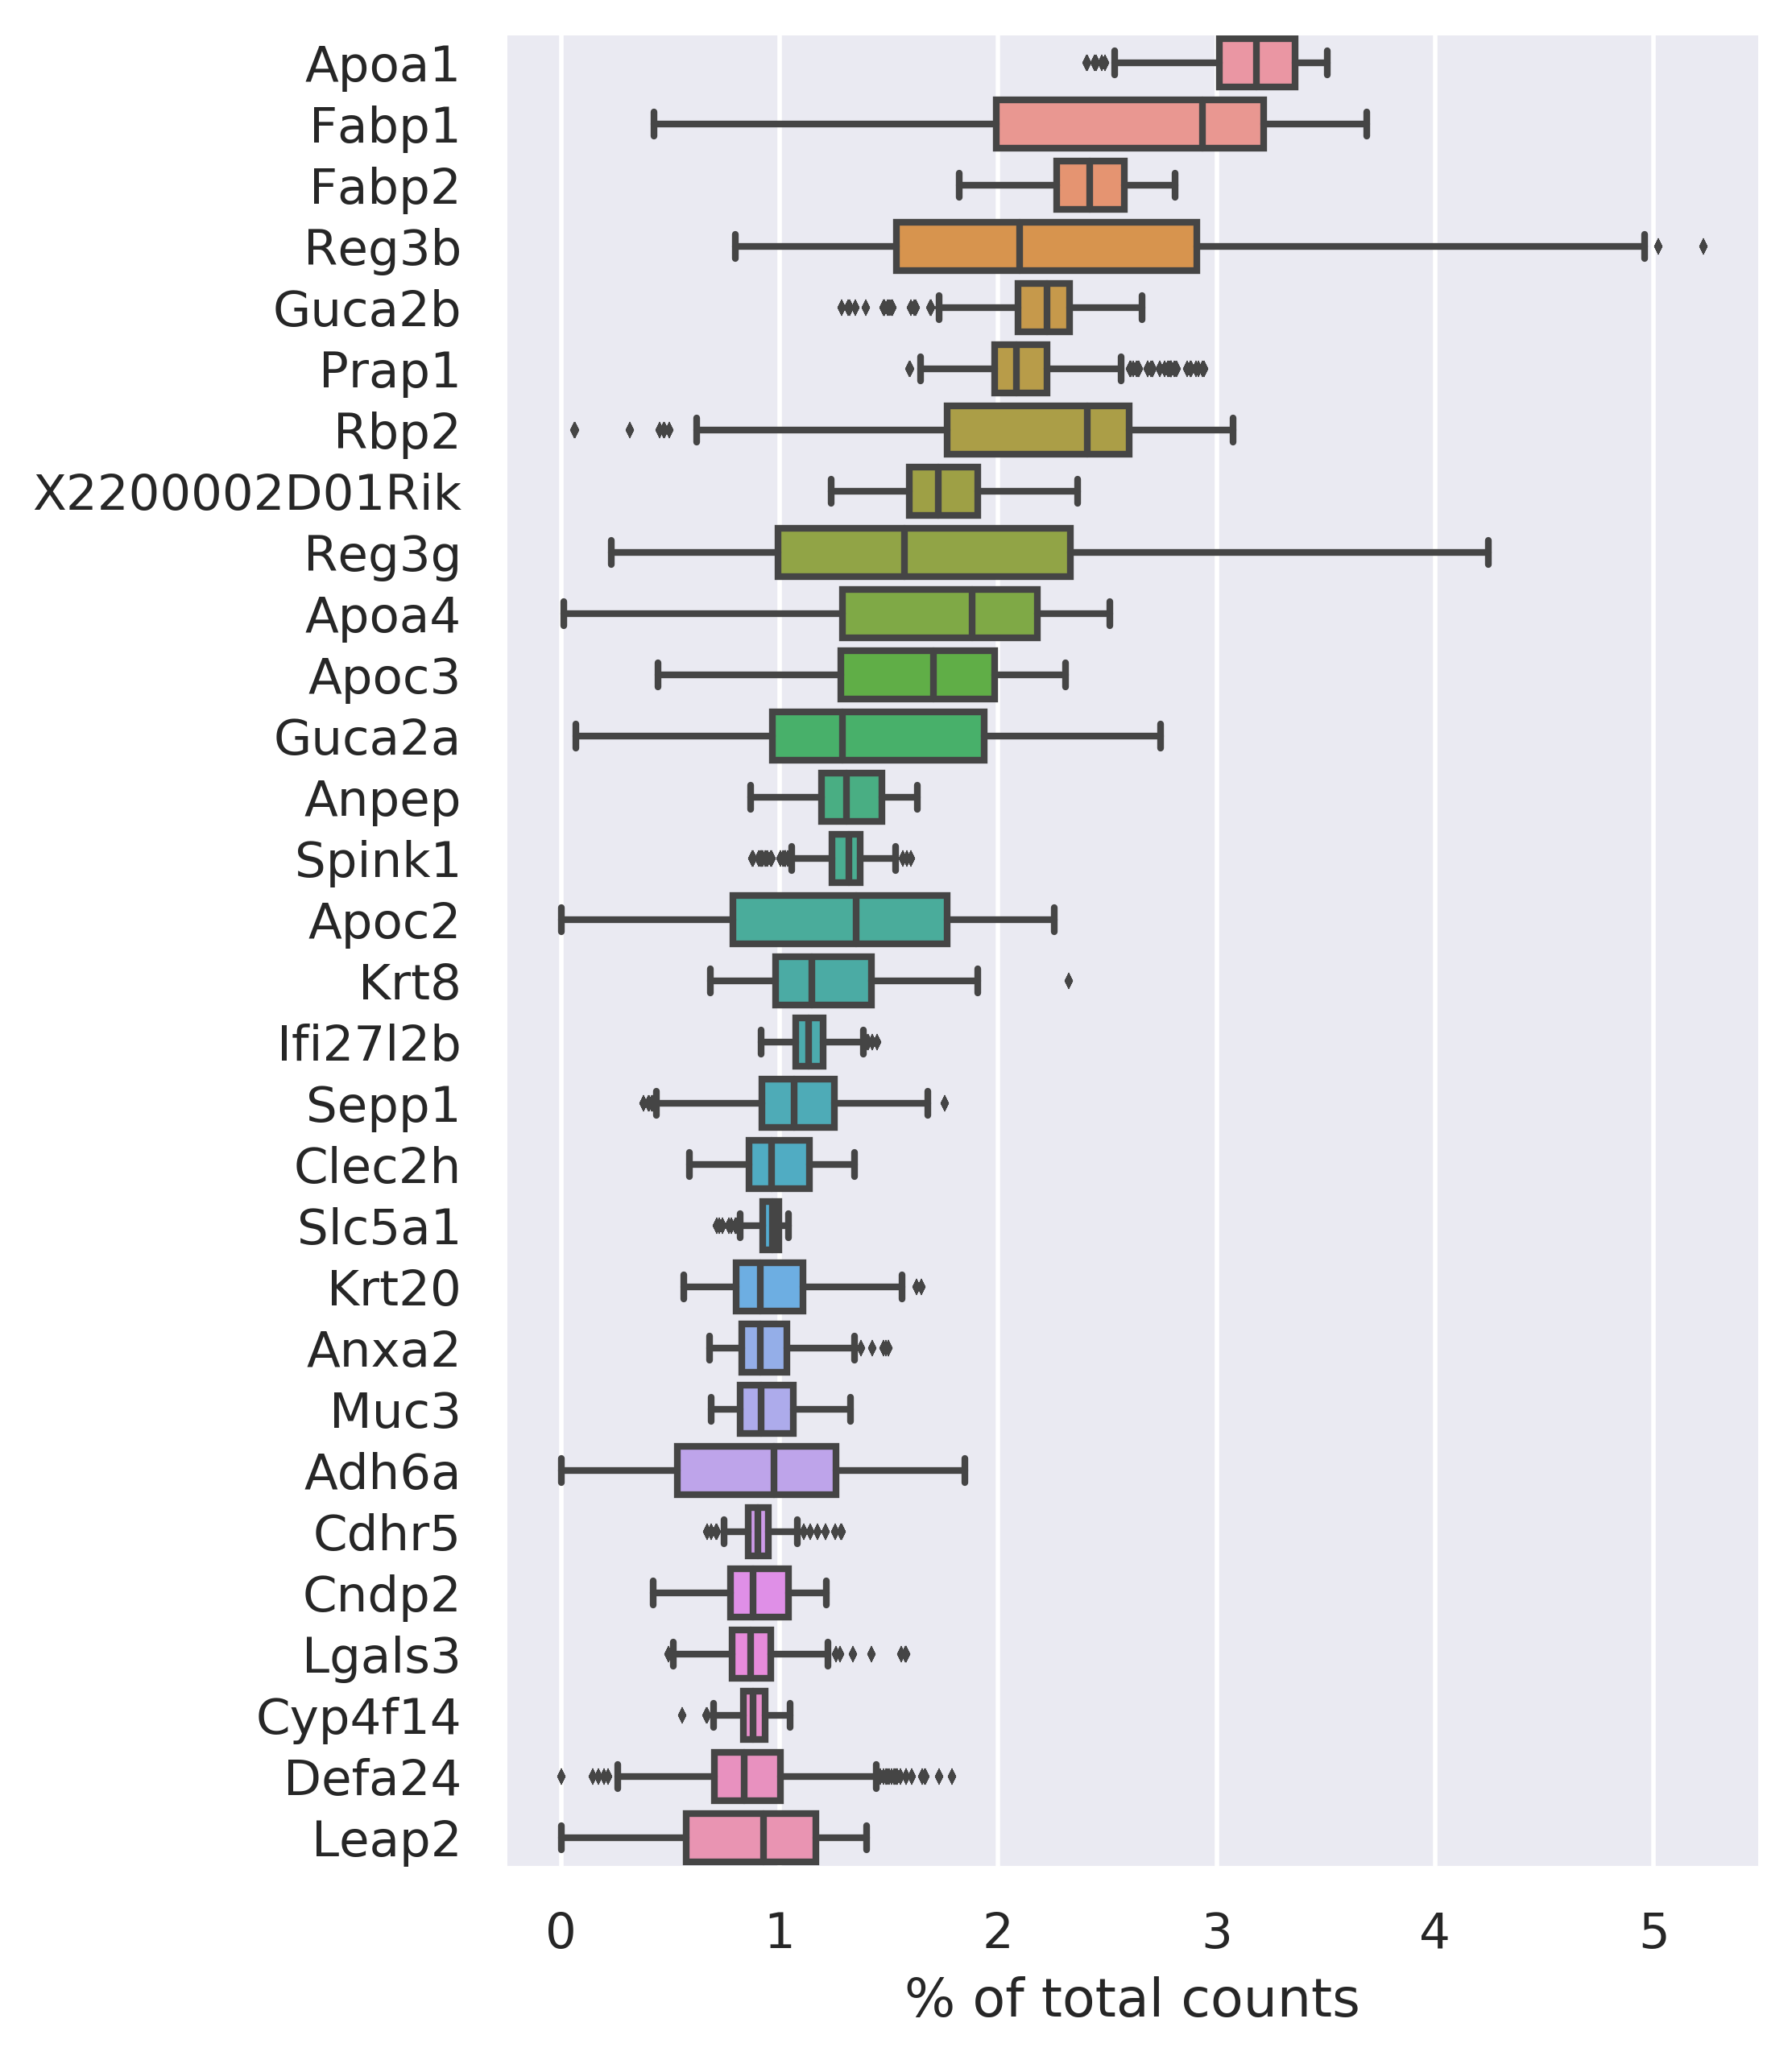

In [58]:
sc.pl.highest_expr_genes(pred_adata)

/home/icb/carlo.dedonno/anaconda3/envs/tf2/lib/python3.7/site-packages/anndata/_core/anndata.py:1172: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'barcode' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_label' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'condition' as categorical


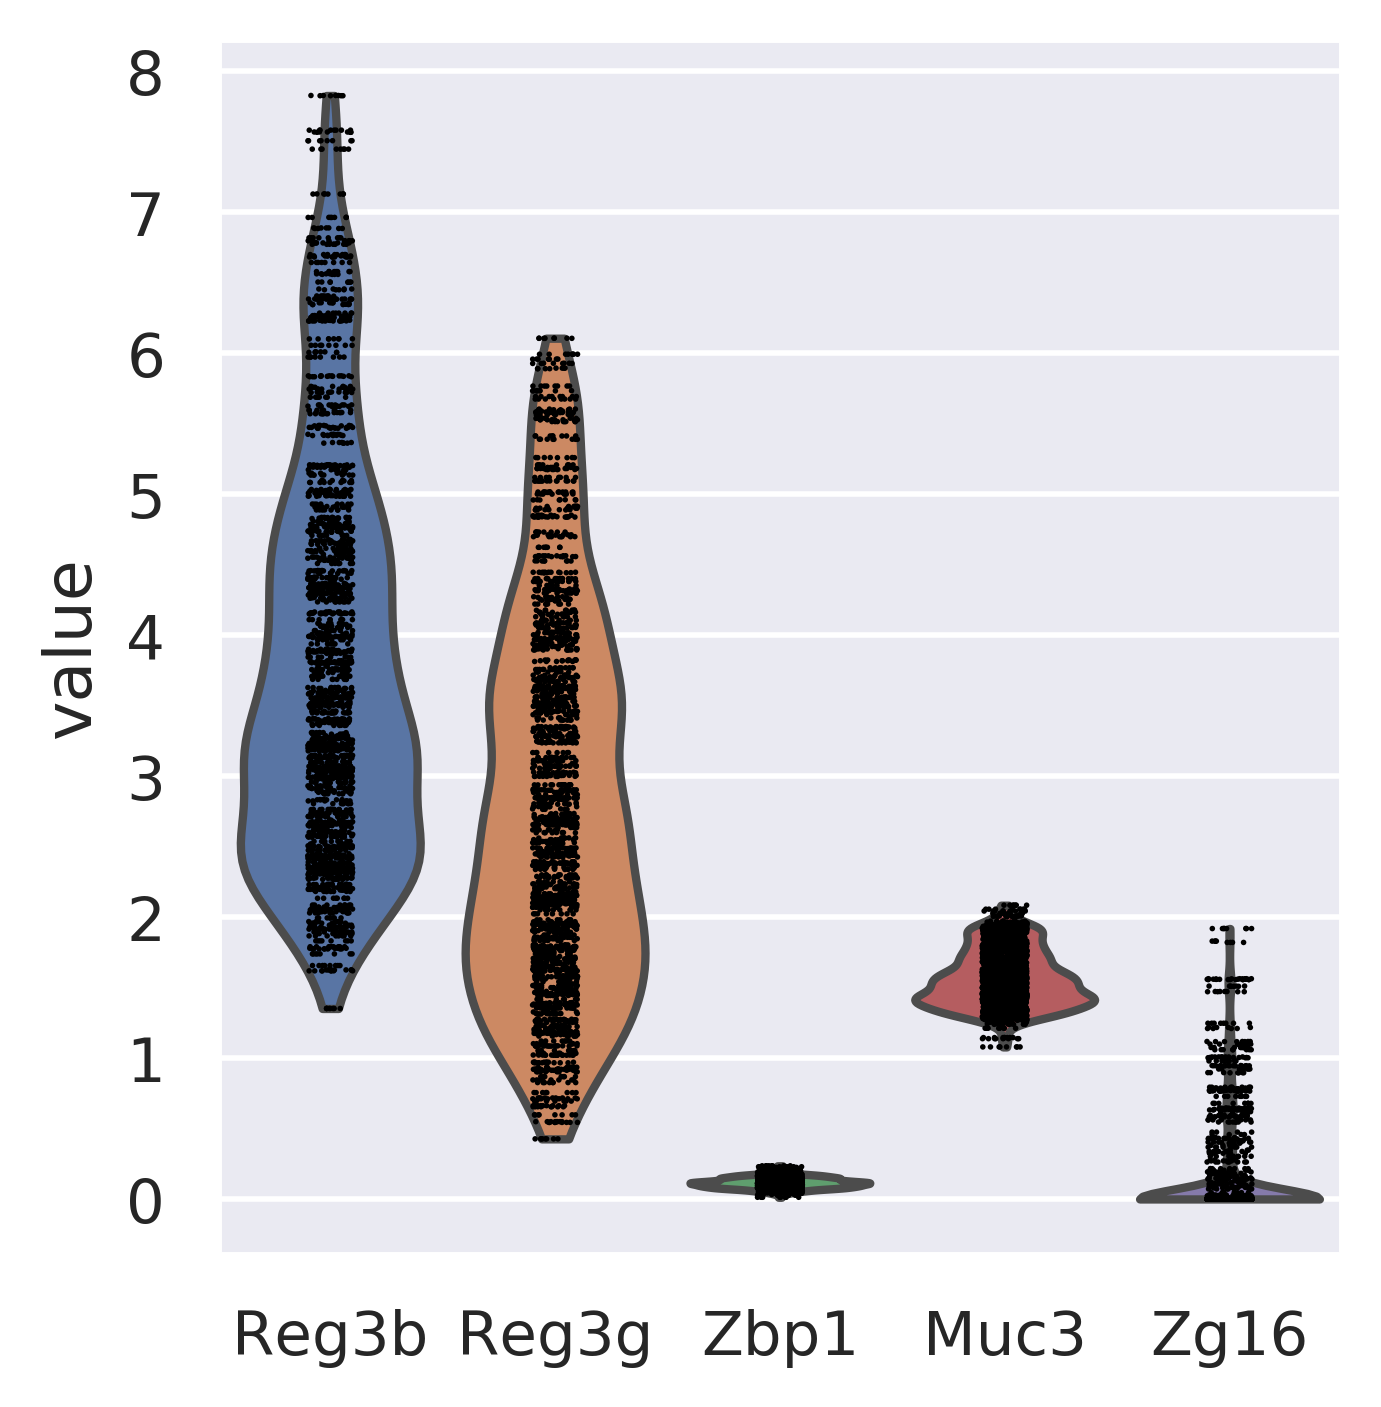

In [62]:
sc.pl.violin(pred_adata, keys=top_genes[:5])

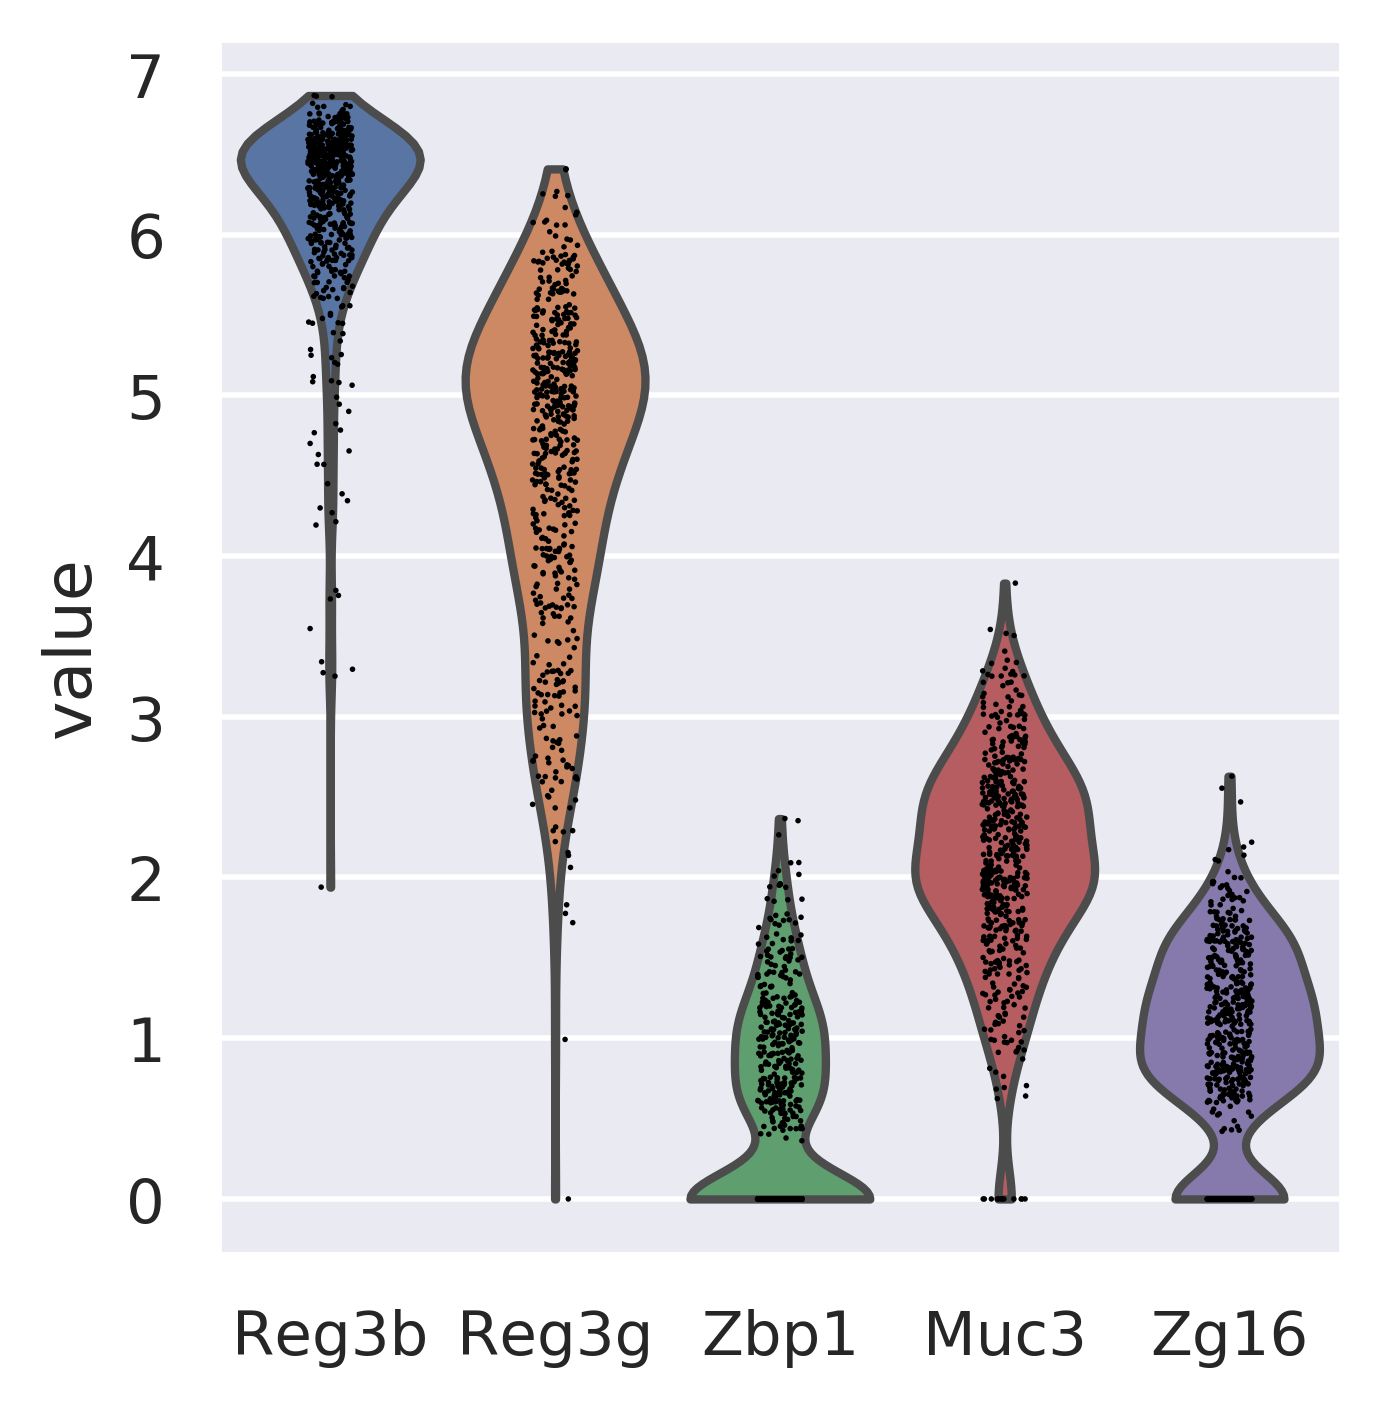

In [63]:
sc.pl.violin(real_adata, keys=top_genes[:5])